# Exploratory data analysis and feature engineering

### In this notebook, we carry out some EDA on the features in the cleaned dataset, and we also engineer some features that measure the students performance in the courses.

In [1]:
import pandas as pd
import numpy as np
import json
import sys
from pathlib import Path

# Add root directory to Python path
root_dir = Path.cwd().parent  # Go up one level from Notebooks folder
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

# Now import from Source Code directory
sys.path.append(str(root_dir / 'Source Code'))
from plotter import *

#import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Automatically reload all modules
%load_ext autoreload
%autoreload 2  

# Set the color palette
palette = {0: 'indianred', 1: 'steelblue'}

#load the dictionaries
with open ('../Data/Dictionaries/crse_dict.json') as f:
    crse_dict = json.load(f)
with open ('../Data/Dictionaries/math_dict.json') as f:
    math_dict = json.load(f)
with open ('../Data/Dictionaries/gen_dict.json') as f:
    gen_dict = json.load(f)

#make the course lists
courses = list(crse_dict.keys())
math_courses = list(math_dict.keys())
gen_courses = list(gen_dict.keys())

#load the cleaned dataset
df = pd.read_csv('../Data/Datasets/dataset_cleaned.csv')
df.sample(5)

,STUDENT,ENT_SEM,GRAD_SEM,165,166,265,143,140,104,150,...,341,385,435,397,436,495,314,500,304,Y
8343,11865,13.6,9.5,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6273,8948,17.6,9.5,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7522,10746,14.6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6946,9916,13.6,9.5,0.0,0.0,0.0,0.0,3.5,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
520,777,17.6,9.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [2]:
#get basic statistics on graduates
y=df['Y']
grads = y.value_counts().get(1, 0)
grad_rate = y.mean()

print(f"Number of graduates: {grads}")
print(f'Total number of students: {len(df)}')
print(f"Graduation rate: {grad_rate}")

Number of graduates: 4496
Total number of students: 9181
Graduation rate: 0.4897070035943797


Recall that our target variable `Y` equals 1 if the student graduated in 9.5 semesters (which is typical if they enroll in fall and graduate in the spring of their fourth year). 

We denote the `grad_rate` for our dataset (i.e. the expected value of `Y`) by $\hat{g}$. Thus,  we have 
\begin{equation*} \hat{g} \coloneqq Pr(Y=1) \approx 0.49. \end{equation*}

First, let's examine how this rate varies among the students who took a math-major course, versus those that took only general math courses. For this, we add a feature `TM` which equals 1 if the student took a math-major course, and 0 otherwise. 

In [3]:
df['TM'] = 0 #TM stands for "took a math-major course"

#get index of students who took at least one math course
math_idx = df[math_courses].abs().sum(axis=1) > 0

#set TOOK_MATH to 1 for students who took at least one math course
df.loc[math_idx, 'TM'] = 1

grad_rate_math = df[df['TM'] == 1]['Y'].mean()
grad_rate_nonmath = df[df['TM'] == 0]['Y'].mean()

print(f"Number of students who took a math-major course: {len(df[df['TM'] == 1])}")
print(f'Grad rate for students who took a math-major course: {grad_rate_math}')
print(f"Number of students who only took general courses: {len(df[df['TM'] == 0])}")
print(f'Grad rate for students who only took general courses: {grad_rate_nonmath}')

Number of students who took a math-major course: 1245
Grad rate for students who took a math-major course: 0.6072289156626506
Number of students who only took general courses: 7936
Grad rate for students who only took general courses: 0.47127016129032256


We find a fairly significant change to the grad rate depending on whether or not a student took a math-major course; denoting these grad rates respectively by $\hat{g}_1$ and $\hat{g}_{0}$, we have
\begin{equation*} \hat{g}_1 \coloneqq Pr(Y=1|TM=1) \approx 0.61 \end{equation*}
and
\begin{equation*} \hat{g}_{0} \coloneqq Pr(Y=1|TM=0) \approx 0.47. \end{equation*}

For each course, the values range from $-9.5$ to $9.5$. The absolute value refers to the semester the course was taken, and the sign refers to whether or not the student "passed" or "failed" (the former means they got a "Satisfactory/pass" or "ABOVE C-", and the latter means they got a "C- or below")

Below, we visualize the distribution of values of the top 3 general math courses on the left, together with the probability of graduating in 9.5 semesters on the right. 

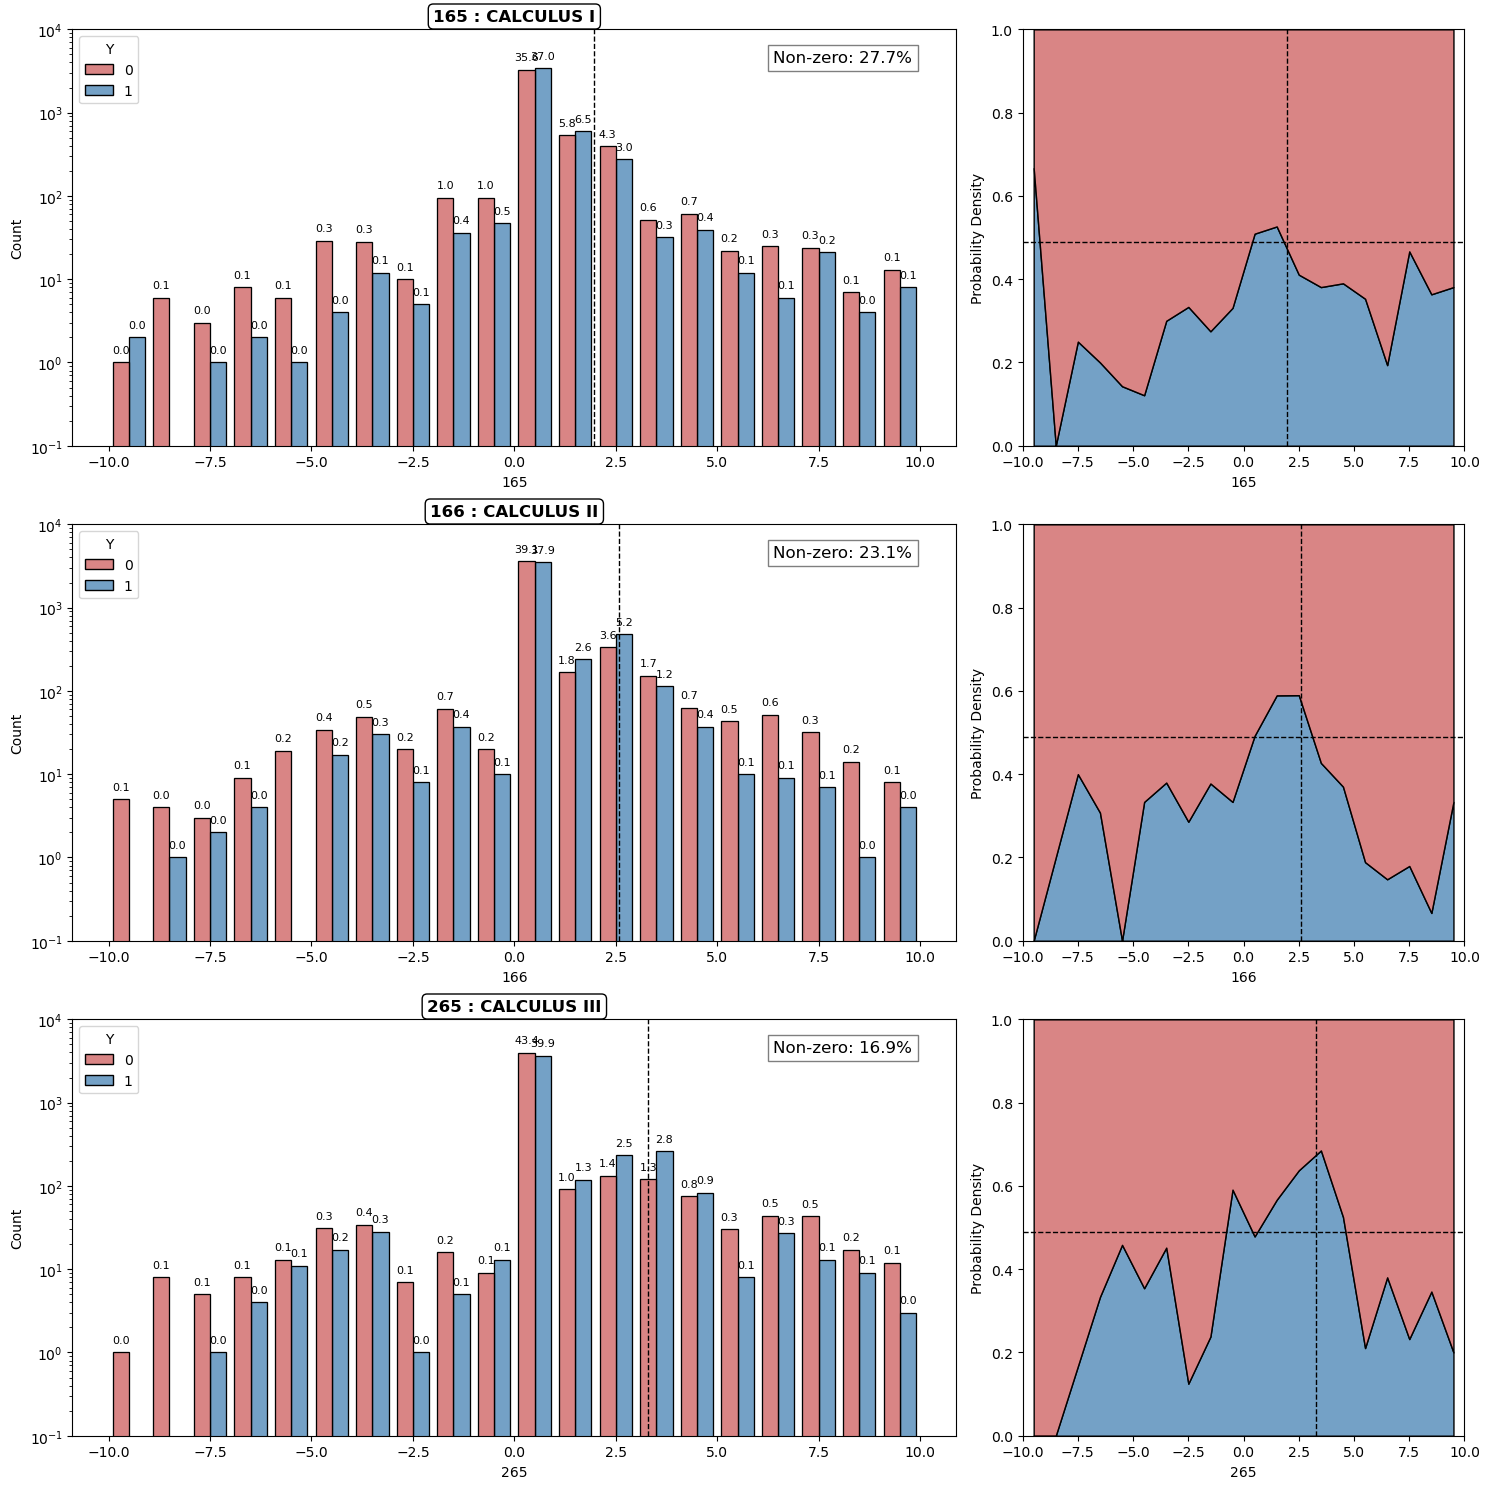

In [4]:
plot_course_hist_density(data=df,
                                 course_list=gen_courses[:3],
                                 crse_dict=crse_dict)

We can identify a few trends from these graphs, but the heavy imbalance in values makes it difficult draw reasonable inferences.

Indeed, the value 0 (indicating that the course was not taken) dominates all the graphs. So, the varying probabilities on the right are not very informative, since the corresponding bin counts tend to be very small (often less than 0.5% of the dataset).

Furthermore, among the students who did take a course, there is again an imbalance, with most of them passing the course. 

To get a better picture, let's replace all negative values with -1 (i.e., we count only the students who failed the course and ignore the semester). We replace the positive values (which simply equal the semester in which the course was taken) with the year in which the course was taken. 

/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_81327/4118628956.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_year[courses] = df_year[courses].applymap(lambda x: sem_to_year(x))


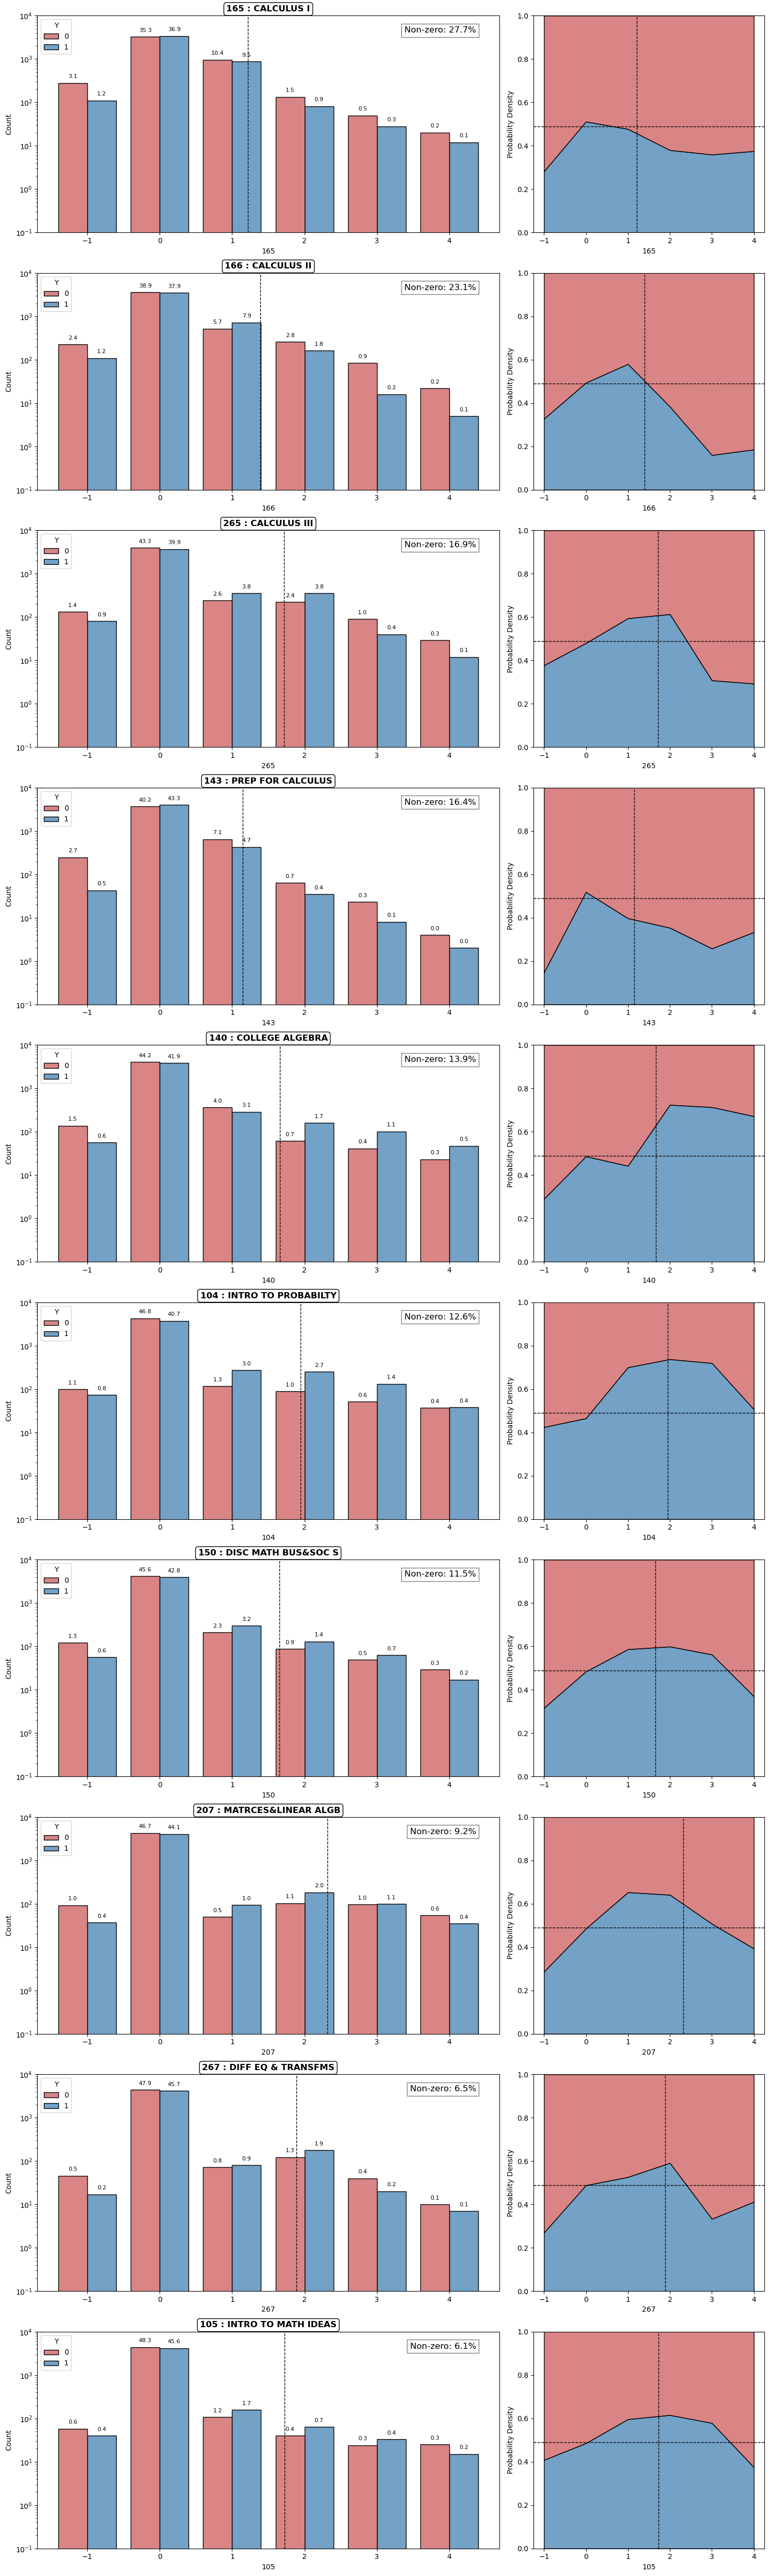

In [5]:
df_year = df.copy()
df_year[courses] = df_year[courses].applymap(lambda x: sem_to_year(x))

plot_course_hist_density(data=df_year,
                                 course_list=gen_courses[:10],
                                 crse_dict=crse_dict,
                                 savefig=True,
                                 savepath='../Data/Plots/gen_course_hist_density.png')

### Notation and setup:

Each course $C$ may be considered as a discrete random variable on the set of students, taking values in $\{-1,0,1,2,3,4\}$:

- $C=-1$ indicates fail (i.e., getting a C- or below);
- $C=0$ indicates the course was not taken; 
- $C = x>0$ indicates that the course was taken and passed in year $x$. 

Let $g(C = x)$ denote the grad rate among students for which $C=x$: 
\begin{equation*} g(C=x) \coloneqq Pr(Y=1|C=x). \end{equation*}

The horizontal lines on the right subplots denote the overall grad rate $\hat{g} \approx 0.49$.

The vertical lines on the right subplots denote the mean among the positive values of $C$, that is, it equals the conditional expectation $E(C|C>0)$.

### Observations on general math courses.

1. For all the courses, we have $$g(C=-1) < \hat{g}.$$
Thus, failing the course is correlated with worse-than-average odds of graduating in 4 years.

2. The courses $143$ (PREP FOR CALCULUS) and $165$ (CALCULUS 1) exhibit an interesting phenomenon-- we have
\begin{equation*} g(C=0) < \hat{g}. \end{equation*} 
That is, **not** taking these courses is correlated with a better-than-average chance of graduating in 4 years. One possible explanation for this is that, among those students majoring in a subject that requires calculus, students who take these courses in college are less mathematically prepared than those who do not (i.e., who took calculus/pre-calculus in high school). 

3. For most of the courses, there is a visible "hill" trend with a peak and downward slopes on either side. For example, for $166$ (CALCULUS II), we find that $g(C=1) > \hat{g}$ (the peak), and $g(C=x)$ gets smaller as $x$ is further away from $1$. 

    Similarly, for the course $265$ (CALCULUS III). We have $g(C=1,2) > \hat{g}$, whereas $g(C = x) < \hat{g}$ if $x=-1,0,3,4$. 

    The take-away from these trends is that graduating in 4 years appears to be correlated not simply with passing the course, but with passing the course "sufficiently early". 

4. The graph for 140 (COLLEGE ALGEBRA) appears to be rather mysterious and counter-intuitive, because it shows that $g(C = x) > \hat{g}$ when $x=2,3,4$. It is not clear why taking college algebra in the last 3 years is correlated with increased odds of Y=1.

Next, we visualize the histograms and probability densities for the top 6 math courses, restricting our attention to students who took a math course. 

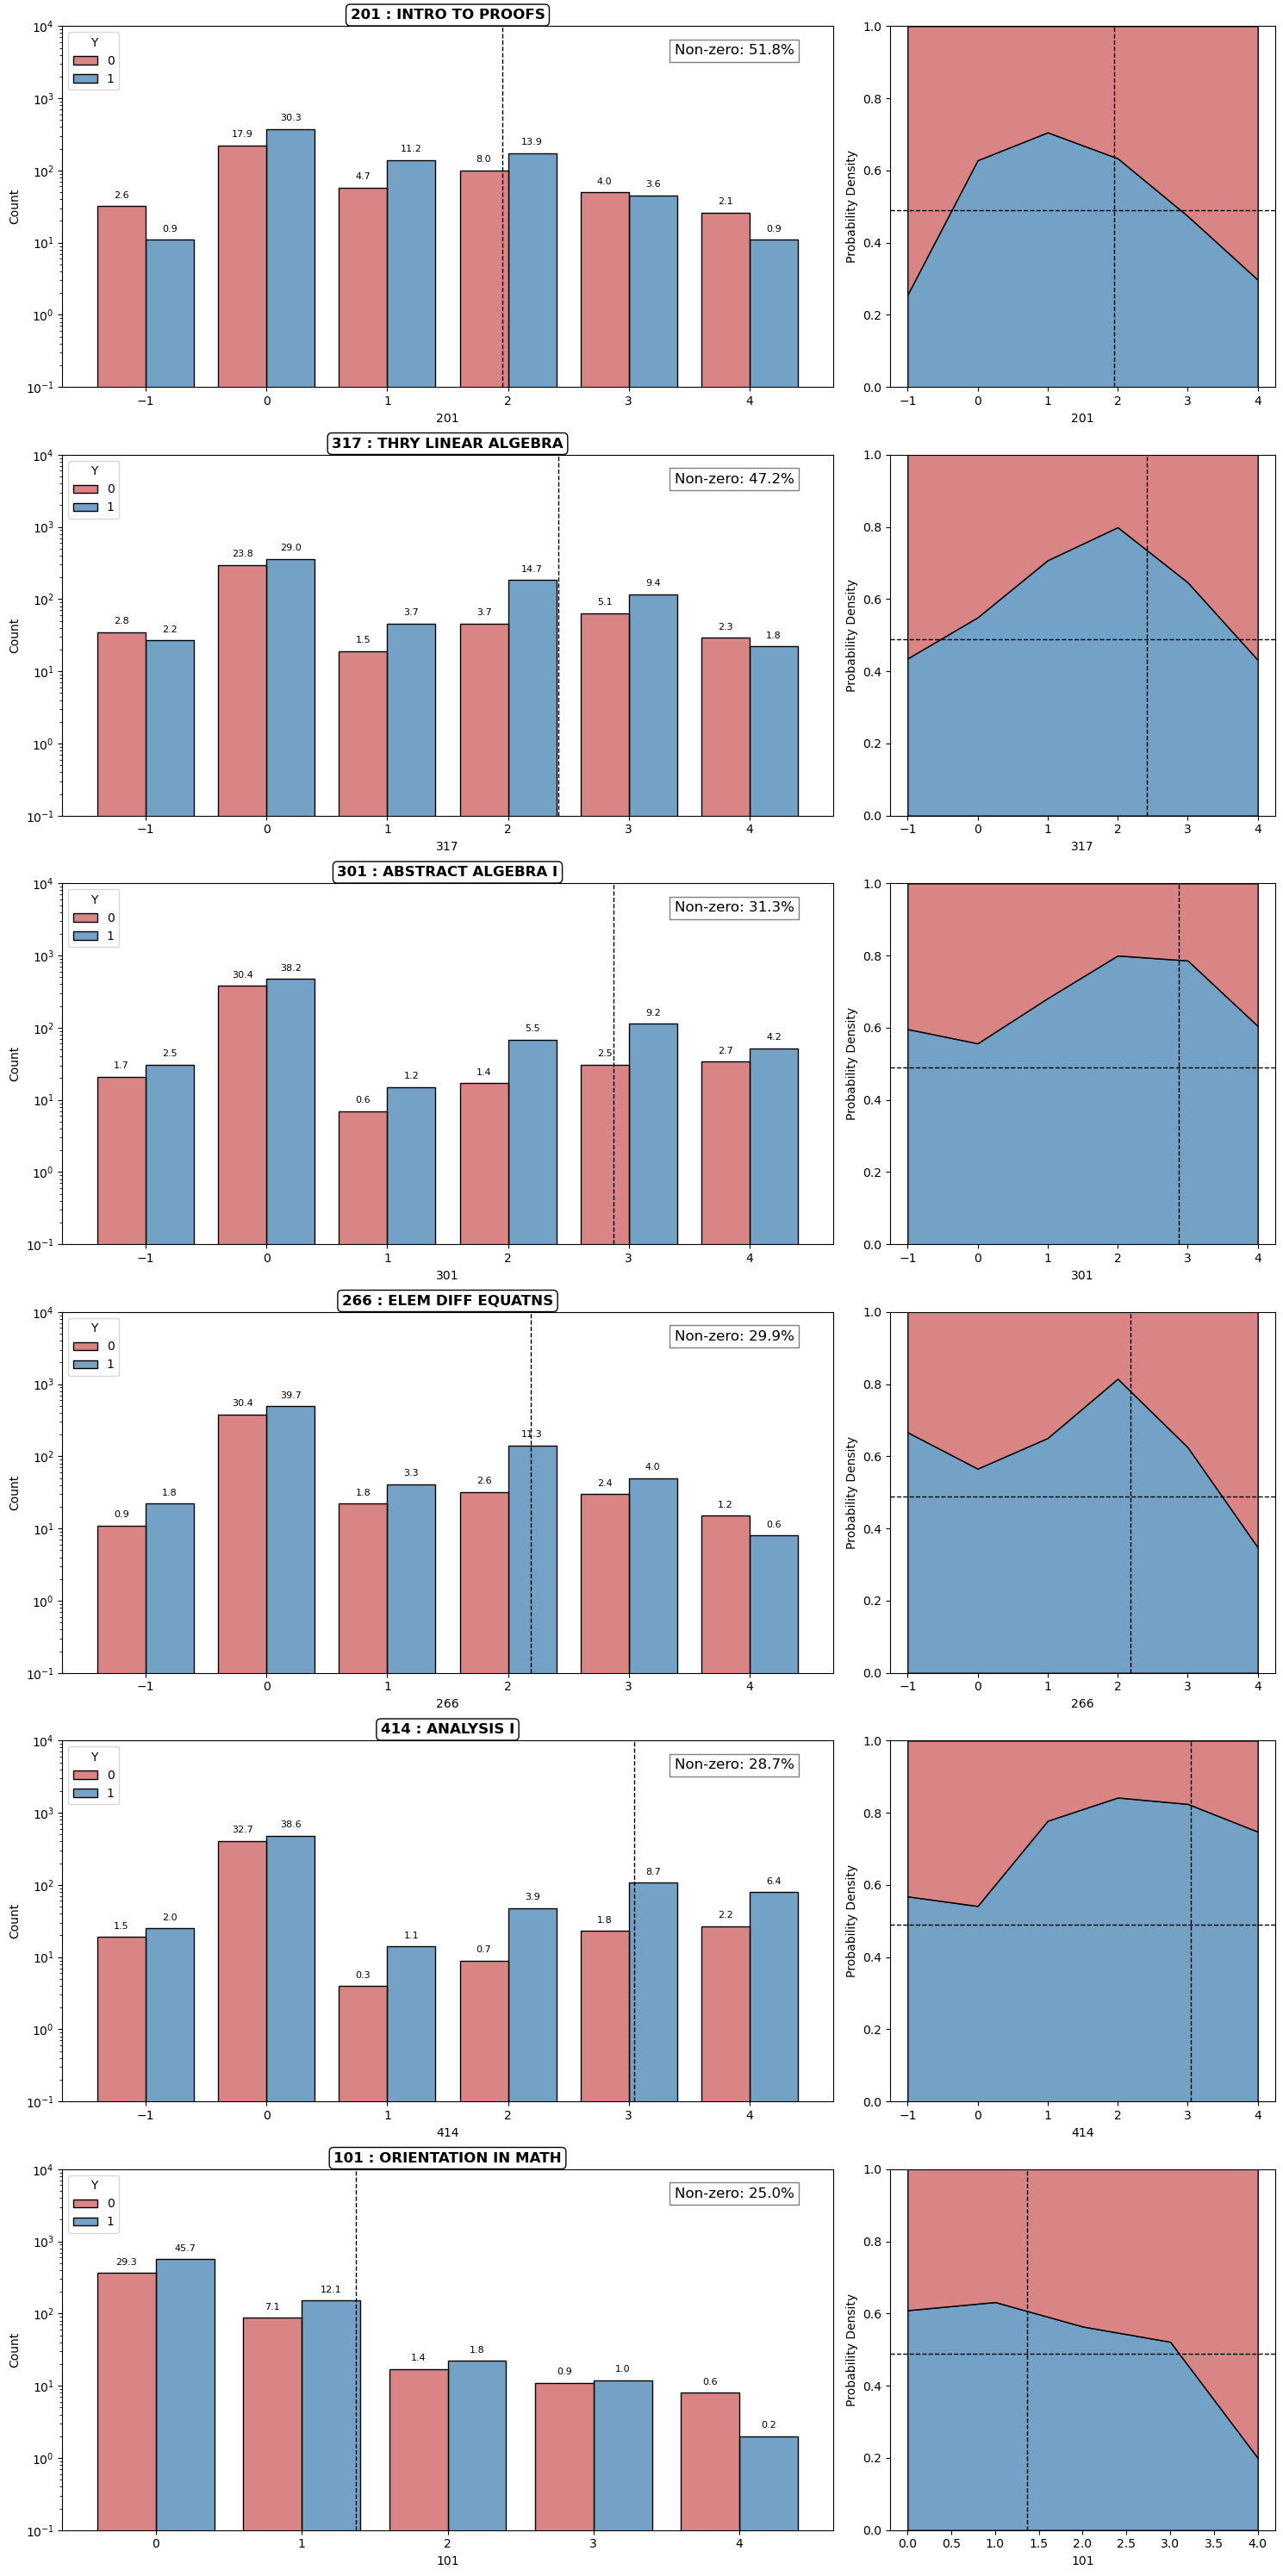

In [6]:
plot_course_hist_density(data=df_year[df_year['TM'] == 1],
                                 course_list=math_courses[:6],
                                 crse_dict=crse_dict,
                                 savefig=True,
                                 savepath='../Data/Plots/math_course_hist_density.png')

### Observations on math major courses.

1. The courses 201 (INTRO TO PROOFS), 314 (THRY LINEAR ALGEBRA) and 101 (ORIENTATION IN MATH) exhibit the same "hill" trend that appeared for most of the general math courses-- we have $$g(C = x) > \hat{g}$$ if the course is taken "early enough", and $$g(C = x) < \hat{g}$$ if the student fails the course or takes it too late.

2. The courses 301 (ABSTRACT ALGEBRA I) and 414 (ANALYSIS I) appear to show a different, interesting trend-- we have $$g(C = x) > \hat{g}$$ if $x \neq 0$. In particular, $$g(C = -1) > \hat{g},$$ indicating that simply taking these courses (and ignoring passing or failing) itself is correlated with better than average odds of graduating in 4 years. This is perhaps not very surprising given that these are more advanced math courses, and students who take these have progressed far enough in their major that they are on track to graduate in 4 years even if they fail these courses.

### Feature engineering

Next, we create some continuous-ish features which are designed to measure the students' academic performance as follows:

1. For each semester $i$ in the list of semesters `sems` (multiples of $0.5$ starting with $0.5$ and ending in $9.5$), we count the number of general, math, and combined courses that were passed, and we subtract from each the number that were failed. We store these values in columns named `SEM_i`, `SEM_i_MATH`, and `SEM_i_GEN` respectively. (Note: `SEM_i` = `SEM_i_MATH` + `SEM_i_GEN`)

    For example, if a student has `SEM_2.0` equal to $1$, then they passed 2 courses more than they failed in semester 2. 

2. Then, we compute the cumulative sums of the above columns as $i$ ranges over the semesters. These are stored in columns named `SEM_i_cdf`, `SEM_i_MATH_cdf`, and `SEM_i_GEN_cdf`, respectively. 

    For example, if a student has `SEM_4.5_cdf` equal to $3$, then within the first 4.5 semesters, the student passed $3$ courses more than they failed. 

    In particular, the columns `SEM_9.5_cdf`, `SEM_9.5_MATH_cdf`, and `SEM_9.5_GEN_cdf` measure the students performance at the end of the four year period under consideration. 

3. Next, for the overall, general course, and math major course performances, we compute lines of best fit for their cumulative performance. These lines capture the "trend" of the students' academic performance across the semesters. 

    For example, if the trend line for a students math-major-course performance is sloping upwards, then it indicates that the student accumulated more passes in math-major-courses as time passed.

3. We store the slope and intercept of each regression line in new columns (`INT` and `SLOPE` for the overall performance, `INT_MATH` and `SLOPE_MATH` for the math-major-course performance, and `INT_GEN` and `SLOPE_GEN` for the general course performance).

In [7]:
df = add_continuous_features(df, courses, math_courses, gen_courses)

Below, we generate some animations to visualize how the distributions of the cumulative math performance changes with the semesters (the animations can be found in the "Plots" folder inside the "Data" folder). 

Specifically, we generate animations of:
- `SEM_i_cdf` for the whole dataset;
- `SEM_i_MATH_cdf` for the students that took a math-major course;
- `SEM_i_GEN_cdf` for the students that took only general math courses.
The displayed images show the final frame of each animation, i.e., the distribution of the cumulative performance after 9.5 semesters in each case. In each image, the vertical line represents the mean value (within the dataset being graphed) of the corresponding cdf performance variable. 

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


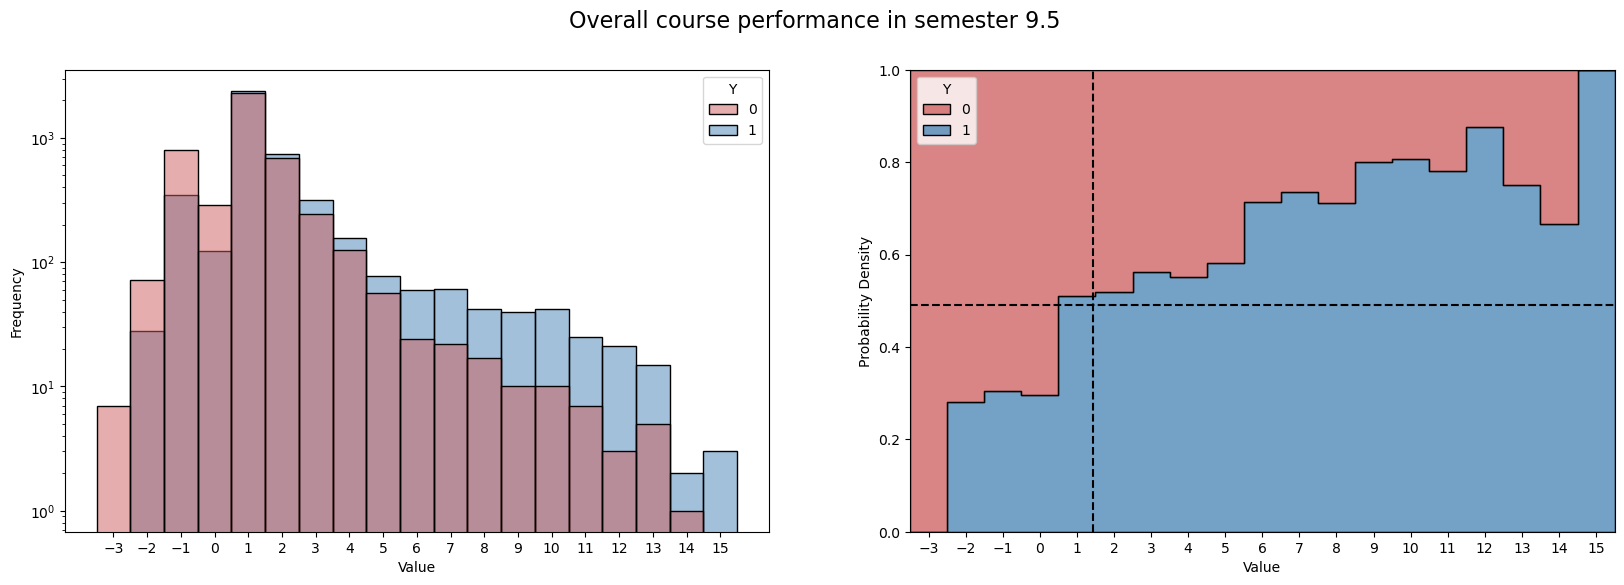

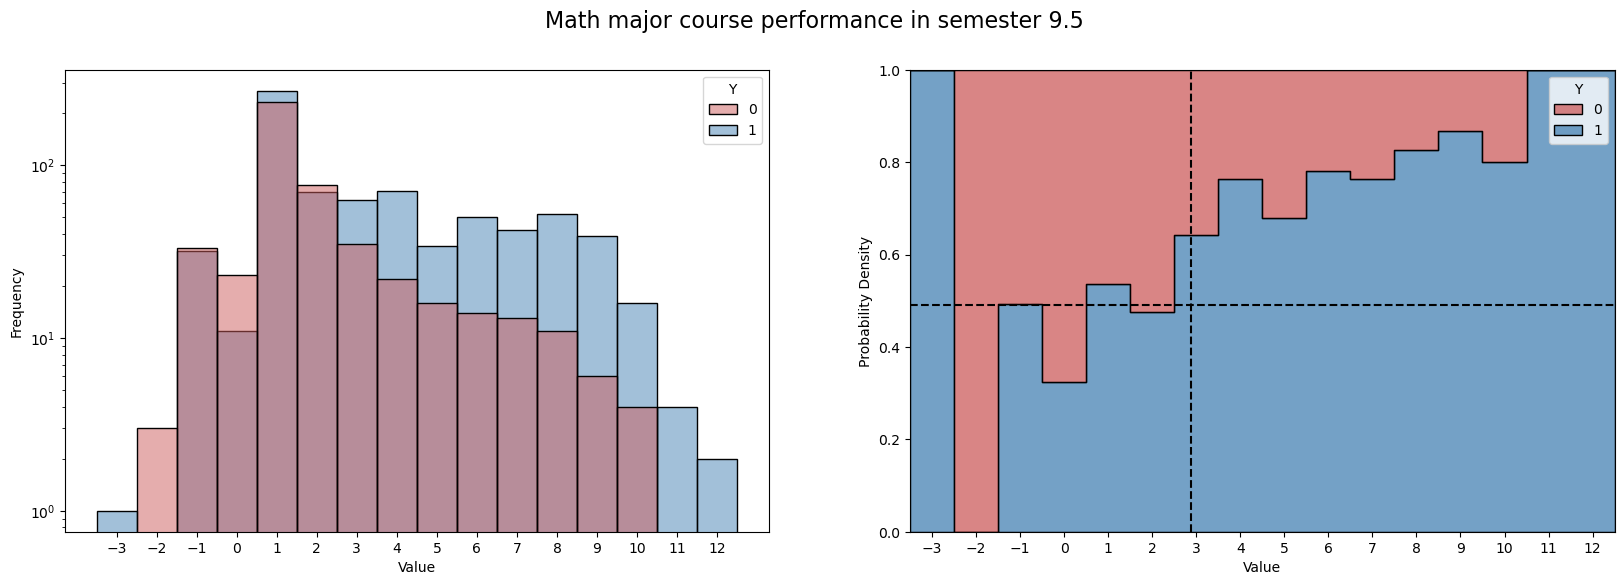

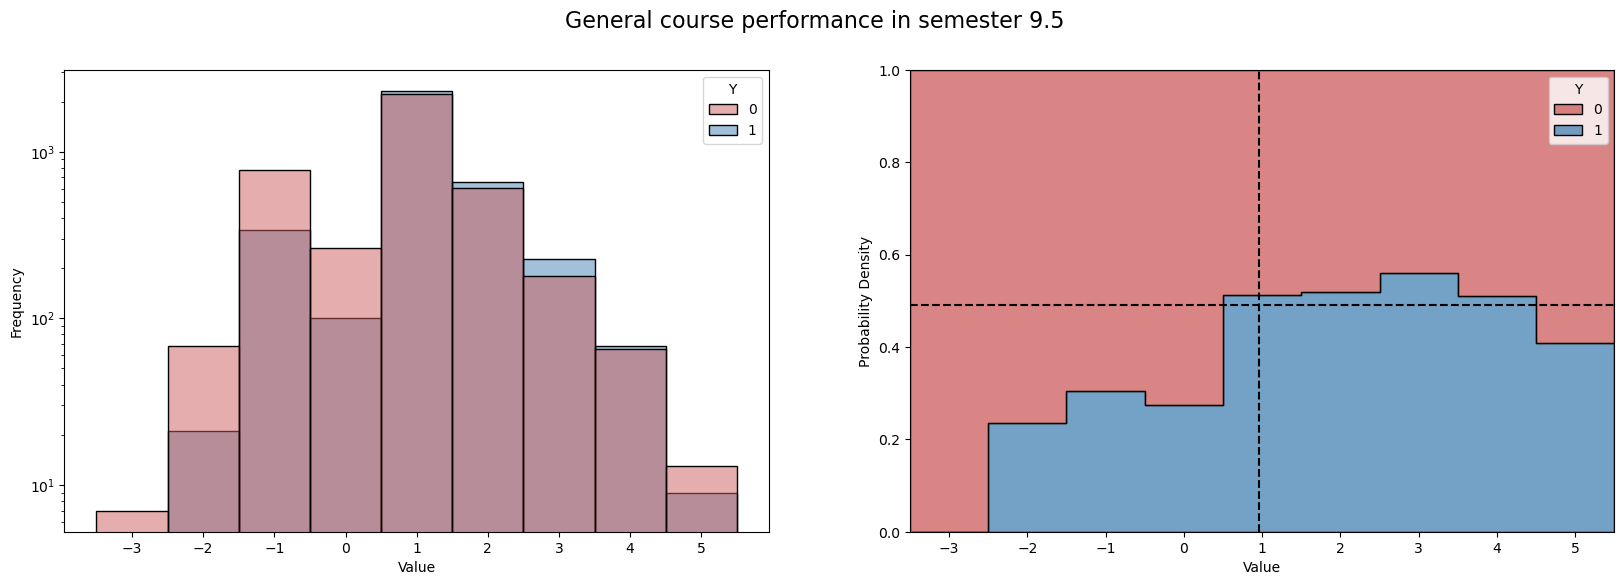

In [8]:
#list of semesters
sems = [0.5*i for i in range(1, 20)]
generate_animations(df, sems)

### Observations on cumulative math performances.

1. From the placement of the vertical lines on the right, we see that:
    - The mean value of `SEM_9.5_cdf` is $\approx 1.5$, which means that the average student had, after 9.5 semesters, passed 1.5 more math courses than they had failed.
    - The mean value of `SEM_9.5_MATH_cdf` is $\approx 3$, which means that the average student who took a math-major course had, after 9.5 semesters, passed $3$ math-major courses more than they had failed.
    - The mean value of `SEM_9.5_GEN_cdf` is $\approx 1$, which means that the average student who took only general math courses had, after 9.5 semesters, passed 1 general math course more than they had failed.

2. The third graph reveals that, among those who only took general math courses, having a worse-than-average performance is correlated with having worse-than-average odds of graduating in 4 years. On the flip-side, we see that having a better-than-average performance does **not** appear to be correlated with the odds of graduating (because the probability of Y=1 appears to be more-or-less the class's grad rate).

3. The first two graphs show a strong positive correlation (within the respect groups of students) between performance and odds of graduating (note: the left-most blue bar in the second graph should be ignored because it counting a single student). Of course, it is quite natural and intuitive that students who fare better in a greater number of math courses are more likely to graduate on time. \
Yet, the first graph reveals a very interesting, somewhat unexpected phenomenon. Indeed, let $S$ denote the performance after 9.5 semesters, and let $\hat{S} \approx 1.5$ denote the mean performance after 9.5 semesters. Then, we see that:
    - If a student's performance is near the mean performance of the whole group, then the student's probability of graduating in 4 years is roughly the same as the overall grad rate: $$Pr(Y=1|S \approx \hat{S}) \approx \hat{g}.$$ 
    - If a student's performance is above the mean performance, then the student's probability of graduating in 4 years is also above the overall grad rate: $$Pr(Y=1|S>\hat{S}) > \hat{g}.$$
    - If a students performance is worse than the mean performance, then the student's probability of graduating in 4 years is also below the overall grad rate: $$Pr(Y=1|S<\hat{S}) < \hat{g}.$$
Moreover, the above phenomenon persists also for most of the semesters leading up to the final semester, which suggests that tracking a student's cumulative math performance might serve as a useful way to identify students at risk of dropping out or not graduating on time.

In [9]:
#save the final dataframe to a csv file named 'dataset_engineered.csv' in the Data folder
df.to_csv('../Data/Datasets/dataset_engineered.csv', index=False)